# Analysis of residential population

In [1]:
#loading data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

#regression
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from statsmodels.formula.api import ols 

#clustering
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score

#mapping
import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt 
import seaborn as sns

## Setting up data

### Loading data

In [72]:
df = pd.read_csv('data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   City                            296 non-null    object 
 1   code                            296 non-null    int64  
 2   ResidentPopulation              296 non-null    int64  
 3   WaterResources                  296 non-null    int64  
 4   AreaofLandforLiving             296 non-null    int64  
 5   AreaofParksandGreen             296 non-null    int64  
 6   GreenCoveredAreaPercentage      296 non-null    float64
 7   VolumeofIndustrialEmission      296 non-null    int64  
 8   MeanConcentrationofPM2.5        296 non-null    int64  
 9   RatioofSewageWork               296 non-null    float64
 10  RateofGarbageTreatment          296 non-null    float64
 11  GrossRegionalProduct            296 non-null    int64  
 12  PerCapitaGRP                    296 

,City,code,ResidentPopulation,WaterResources,AreaofLandforLiving,AreaofParksandGreen,GreenCoveredAreaPercentage,VolumeofIndustrialEmission,MeanConcentrationofPM2.5,RatioofSewageWork,...,TotalRetailSales,AverageWageofEmployees,Numberofschool,NumberofTeachers,CollectionsofPublicLibraries,NumberofMuseums,NumberofHospitals,NumberofLicensedDoctors,AreaofUrbanPavedRoads,HighwayPassengerTraffic
0,Beijing,1101,2189,257600,21981,35720,48.96,4376,38,99.3,...,137163960,185026,1590,130127,7241,183,733,118541,10654,24548
1,Tianjin,1202,1387,132900,289,12114,37.59,10053,48,99.3,...,35829079,118918,1415,93486,2175,71,423,49236,17510,7926
2,Shijiazhuang,1301,1124,176100,94,5003,42.85,24707,58,99.3,...,23826607,84870,1899,94241,418,13,328,43597,6332,1150
3,Tangshan,1302,772,170500,62,3588,42.33,61528,49,99.0,...,20275562,82483,1473,67899,743,17,209,24878,4580,799
4,Qinhuangdao,1303,314,93900,40,2406,41.20,8202,34,97.0,...,5644041,85609,580,29193,179,6,66,9764,2436,249


### data cleaning

In [73]:
# detecting null value
df.isnull().sum(axis=0).sort_values(ascending=False)[0:30]


City                              0
PublicBudgetExpenditure           0
AreaofUrbanPavedRoads             0
NumberofLicensedDoctors           0
NumberofHospitals                 0
NumberofMuseums                   0
CollectionsofPublicLibraries      0
NumberofTeachers                  0
Numberofschool                    0
AverageWageofEmployees            0
TotalRetailSales                  0
NumberofIndustrialEnterprises     0
ResidentialBuildings              0
SalesAreaofCommercialResidence    0
ExpenditureforEducation           0
TertiaryIndustryasPercentage      0
code                              0
SecondaryIndustryasPercentage     0
GRPGrowthRate                     0
PerCapitaGRP                      0
GrossRegionalProduct              0
RateofGarbageTreatment            0
RatioofSewageWork                 0
MeanConcentrationofPM2.5          0
VolumeofIndustrialEmission        0
GreenCoveredAreaPercentage        0
AreaofParksandGreen               0
AreaofLandforLiving         

## Distribution of residential population

In [7]:
import geopandas as gpd
cities = gpd.read_file('./Chinacity/CN_city_dissolve.shp')

In [8]:
cities.info()
cities.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   shi_code  349 non-null    int64   
 1   SUM_AREA  349 non-null    float64 
 2   geometry  349 non-null    geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 8.3 KB


,shi_code,SUM_AREA,geometry
0,0,5.125000e+01,"POLYGON ((1845931.625 2868094.000, 1845934.125..."
1,1101,1.218520e+10,"POLYGON ((959543.875 4466805.500, 959577.688 4..."
2,1102,4.221190e+09,"MULTIPOLYGON (((945780.563 4441950.000, 945796..."
3,1201,7.327470e+09,"POLYGON ((1028482.312 4344273.000, 1028553.688..."
4,1202,4.359360e+09,"MULTIPOLYGON (((1008171.500 4253594.000, 10082..."


In [9]:
joined = cities.merge(df,left_on = 'shi_code', right_on ='code', how='left')
joined.info()
joined.head(1)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 349 entries, 0 to 348
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   shi_code                                         349 non-null    int64   
 1   SUM_AREA                                         349 non-null    float64 
 2   geometry                                         349 non-null    geometry
 3   City                                             286 non-null    object  
 4   code                                             286 non-null    float64 
 5   ResidentPopulation                               286 non-null    float64 
 6   TotalWaterResources                              286 non-null    float64 
 7   AreaofLandUsedforLiving                          286 non-null    float64 
 8   AreaofParksandGreenLand                          286 non-null    float64 
 9   GreenCoveredA

,shi_code,SUM_AREA,geometry,City,code,ResidentPopulation,TotalWaterResources,AreaofLandUsedforLiving,AreaofParksandGreenLand,GreenCoveredAreaasofCompletedArea,...,TotalRetailSalesofConsumerGoods,AverageWageofEmployedWorkers,Numberofschool,NumberofFull-timeTeachers,CollectionsofPublicLibraries,NumberofMuseums,NumberofHospitals,NumberofLicensedDoctors,AreaofUrbanPavedRoadsatYear-end,HighwayPassengerTraffic
0,0,51.25,"POLYGON ((1845931.625 2868094.000, 1845934.125...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AttributeError: 'NoneType' object has no attribute 'set_title'

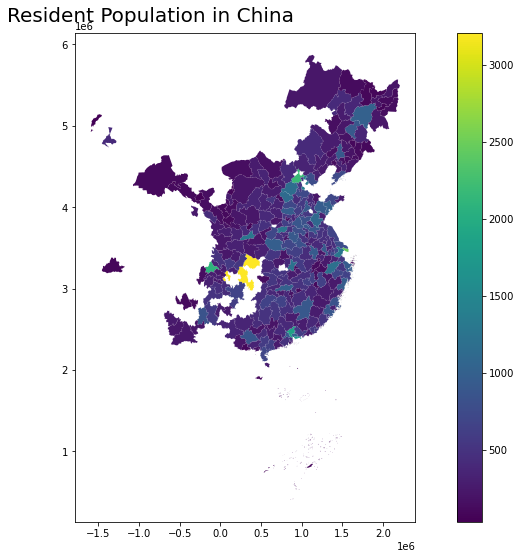

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,9))
fig.suptitle(f"Resident Population in China", fontsize=20, y=0.92)
joined.plot(ax=ax, column='ResidentPopulation',legend=True)


ax.get_legend().set_title("Resident Population")  #set the legend title


cities.plot(ax=ax,color='#17becf')
ax.axis('off') #don't plot the axes (bounding box)

##save image
#plt.savefig('cluster_map.png')

## Principal component analysis 

In [74]:
# select data set
factors = df.drop(columns = ['City', 'code', 'ResidentPopulation'])
factors.head()

,WaterResources,AreaofLandforLiving,AreaofParksandGreen,GreenCoveredAreaPercentage,VolumeofIndustrialEmission,MeanConcentrationofPM2.5,RatioofSewageWork,RateofGarbageTreatment,GrossRegionalProduct,PerCapitaGRP,...,TotalRetailSales,AverageWageofEmployees,Numberofschool,NumberofTeachers,CollectionsofPublicLibraries,NumberofMuseums,NumberofHospitals,NumberofLicensedDoctors,AreaofUrbanPavedRoads,HighwayPassengerTraffic
0,257600,21981,35720,48.96,4376,38,99.3,100.0,36103,164889,...,137163960,185026,1590,130127,7241,183,733,118541,10654,24548
1,132900,289,12114,37.59,10053,48,99.3,100.0,14084,101614,...,35829079,118918,1415,93486,2175,71,423,49236,17510,7926
2,176100,94,5003,42.85,24707,58,99.3,100.0,5935,52961,...,23826607,84870,1899,94241,418,13,328,43597,6332,1150
3,170500,62,3588,42.33,61528,49,99.0,100.0,7211,93470,...,20275562,82483,1473,67899,743,17,209,24878,4580,799
4,93900,40,2406,41.20,8202,34,97.0,100.0,1686,53821,...,5644041,85609,580,29193,179,6,66,9764,2436,249


In [75]:
# Bartlett's test
# to examinate the independence of each variable

chi_square_value, p_value = calculate_bartlett_sphericity(factors)
print(chi_square_value, p_value)

10648.555066144643 0.0


In [76]:
#KMO test
kmo_all, kmo_model = calculate_kmo(factors)
print(kmo_all)
print(kmo_model)

[0.56212194 0.64873563 0.87369571 0.6525711  0.30720762 0.76356605
 0.50541452 0.56303903 0.89354688 0.83619741 0.30252006 0.49953818
 0.83419121 0.88473298 0.87988261 0.83717821 0.83827816 0.8280354
 0.93741749 0.91882014 0.83514806 0.86210105 0.8515594  0.95778974
 0.94286925 0.91425911 0.87014964 0.85442867]
0.8635962277518743


In [77]:
# correlation metrix

covX = np.around(np.corrcoef(factors.T),decimals=3)
covX

array([[ 1.   , -0.02 ,  0.04 ,  0.009,  0.052, -0.17 , -0.046, -0.122,
         0.032, -0.085,  0.088, -0.056, -0.025,  0.08 ,  0.084,  0.146,
         0.134,  0.033,  0.056, -0.076,  0.111,  0.14 ,  0.014,  0.032,
         0.074,  0.061,  0.027,  0.096],
       [-0.02 ,  1.   ,  0.522,  0.059, -0.015,  0.035,  0.021,  0.016,
         0.431,  0.198, -0.027, -0.132,  0.268,  0.515,  0.525,  0.065,
         0.054,  0.077,  0.412,  0.294,  0.11 ,  0.211,  0.309,  0.433,
         0.37 ,  0.488,  0.172,  0.223],
       [ 0.04 ,  0.522,  1.   ,  0.141,  0.035,  0.127, -0.02 ,  0.065,
         0.899,  0.499,  0.004, -0.118,  0.516,  0.89 ,  0.901,  0.616,
         0.6  ,  0.521,  0.891,  0.511,  0.364,  0.632,  0.629,  0.719,
         0.715,  0.881,  0.826,  0.386],
       [ 0.009,  0.059,  0.141,  1.   ,  0.006,  0.224,  0.316,  0.338,
         0.081,  0.157,  0.017,  0.074, -0.034,  0.077,  0.093,  0.09 ,
         0.103, -0.015,  0.082, -0.03 ,  0.132,  0.127,  0.064,  0.088,
         0.09

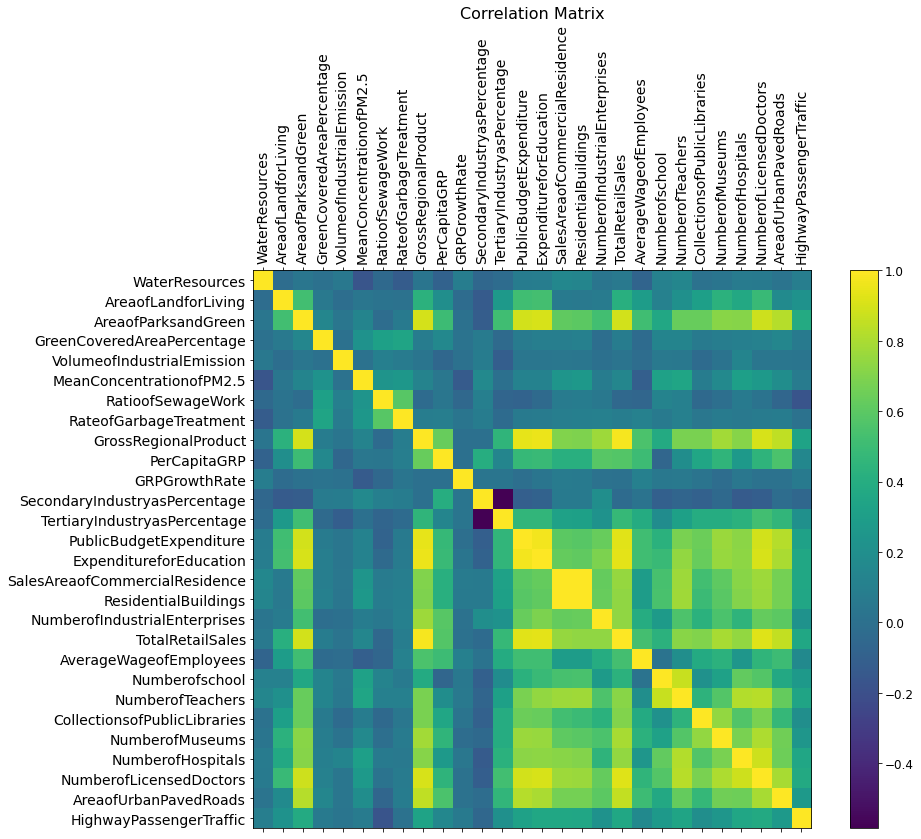

In [110]:
# correlation matrix
df1 = factors
f = plt.figure(figsize=(14, 10)) 
plt.matshow(df1.corr(), fignum=f.number)
plt.xticks(range(df1.shape[1]), df1.columns, fontsize=14, rotation=90)
plt.yticks(range(df1.shape[1]), df1.columns, fontsize=14)
# legend
cb = plt.colorbar(fraction=0.05, pad=0.05) 
cb.ax.tick_params(labelsize=12)

plt.title('Correlation Matrix', fontsize=16) 
plt.savefig('correlation matrix.png', bbox_inches='tight')

In [79]:
#  Eigenvalues and Eigenvectors of Coefficient Correlation Matrix
featValue, featVec=  np.linalg.eig(covX.T) 

# descending featValue
featValue = sorted(featValue)[::-1]
featValue

[11.956570437720853,
 2.3892826212630203,
 2.0447185839929785,
 1.6907885186663536,
 1.191419782097014,
 1.1415250522276787,
 1.0040207802844192,
 0.9421984724861113,
 0.8564958737701568,
 0.7544926820980076,
 0.6935132339825208,
 0.575965993386884,
 0.5158725899834029,
 0.477834530952793,
 0.3626965217107915,
 0.292637234198668,
 0.2452104678926075,
 0.2323327449363953,
 0.19220637345870475,
 0.1751999105947047,
 0.08084417905739348,
 0.06163262758708465,
 0.04298232551117701,
 0.03433631526048938,
 0.02468039884887033,
 0.010355761523775943,
 0.007942679689624012,
 0.0022433068175253803]

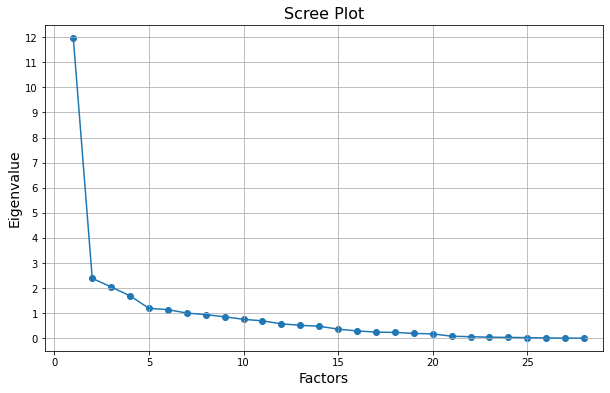

<Figure size 432x288 with 0 Axes>

In [80]:
# plotting
f = plt.figure(figsize=(10, 6)) 
plt.scatter(range(1, df1.shape[1] + 1), featValue)
plt.plot(range(1, df1.shape[1] + 1), featValue)

plt.title("Scree Plot",fontsize=16)  
plt.xlabel("Factors",fontsize=14)
plt.ylabel("Eigenvalue",fontsize=14)

from matplotlib.pyplot import MultipleLocator

#setting the label 
x_major_locator = MultipleLocator(5)
y_major_locator = MultipleLocator(1) 

ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#setting y axis range
plt.xlim(-0.5,29)
#setting y axis range
plt.ylim(-0.5,12.5)

#for y in zip( featValue):
#    plt.text(y+0.3, '%.0f' % y, ha='center', va='bottom', fontsize=10.5)


plt.grid() 
plt.show() 
plt.savefig('Scree plot.png')

### 7 factors

In [19]:
# choose 7 factors
faa_7 = FactorAnalyzer(7,rotation='varimax')
faa_7.fit(df1)

FactorAnalyzer(n_factors=7, rotation='varimax', rotation_kwargs={})

In [20]:
# common factor variance
faa_7.get_communalities()

array([0.15179996, 0.54511057, 0.86909135, 0.18737824, 0.03975125,
       0.69942742, 0.68758504, 0.56046384, 0.98563035, 0.7229727 ,
       0.04451856, 0.80503965, 0.73024278, 0.94465434, 0.98906553,
       0.96298068, 0.95431796, 0.64234892, 0.96666979, 0.45891307,
       0.75557606, 0.97722432, 0.61673231, 0.76990184, 0.80977558,
       0.98169081, 0.82620635, 0.17269277])

In [21]:
pd.DataFrame(faa_7.get_communalities(),index=df1.columns)

,0
TotalWaterResources,0.151800
AreaofLandUsedforLiving,0.545111
AreaofParksandGreenLand,0.869091
GreenCoveredAreaasofCompletedArea,0.187378
VolumeofIndustrialParticulateEmission,0.039751
AnnualMeanConcentrationofPM2.5,0.699427
RatioofWasteWaterCentralizedTreatedofSewageWork,0.687585
RateofDomesticGarbageHarmlessTreatment,0.560464
GrossRegionalProduct,0.985630
PerCapitaGRP,0.722973


In [22]:
#eigenvalue after rotation
faa_7.get_eigenvalues()

(array([1.19563840e+01, 2.38905010e+00, 2.04482246e+00, 1.69012530e+00,
        1.19137617e+00, 1.14176585e+00, 1.00391677e+00, 9.41802131e-01,
        8.56948893e-01, 7.54008853e-01, 6.93853175e-01, 5.76477312e-01,
        5.16171868e-01, 4.78064651e-01, 3.62579339e-01, 2.92883108e-01,
        2.45152920e-01, 2.32759720e-01, 1.92512408e-01, 1.74951158e-01,
        8.12973965e-02, 6.13335747e-02, 4.25467016e-02, 3.41863037e-02,
        2.48568648e-02, 9.86422386e-03, 7.76483072e-03, 2.54396312e-03]),
 array([ 1.18158125e+01,  2.08363275e+00,  1.77043947e+00,  1.32485267e+00,
         8.15815723e-01,  5.89092959e-01,  4.58120281e-01,  3.40936115e-01,
         2.57596769e-01,  1.92195000e-01,  1.51936382e-01,  1.36783040e-01,
         4.13731944e-02,  2.77765060e-02,  9.53102389e-03, -5.57486676e-03,
        -1.18773634e-02, -1.65332454e-02, -2.78580987e-02, -3.59236692e-02,
        -4.27573289e-02, -6.12949951e-02, -9.14073327e-02, -1.07622794e-01,
        -1.44639484e-01, -1.78056868e-

In [23]:
pd.DataFrame(faa_7.get_eigenvalues())

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,11.956384,2.389050,2.044822,1.690125,1.191376,1.141766,1.003917,0.941802,0.856949,0.754009,...,0.192512,0.174951,0.081297,0.061334,0.042547,0.034186,0.024857,0.009864,0.007765,0.002544
1,11.815812,2.083633,1.770439,1.324853,0.815816,0.589093,0.458120,0.340936,0.257597,0.192195,...,-0.027858,-0.035924,-0.042757,-0.061295,-0.091407,-0.107623,-0.144639,-0.178057,-0.207787,-0.226799


In [24]:
# number of variables*number of factors
faa_7.loadings_

array([[-9.97887211e-03,  1.69019050e-01, -1.47669603e-02,
        -8.45747741e-02,  2.52447516e-02,  3.70021760e-02,
         3.37276640e-01],
       [ 3.90397356e-01,  3.67898851e-02,  1.10270269e-01,
         3.46570214e-02,  6.05519536e-01,  6.66744035e-02,
        -8.29876915e-02],
       [ 8.53241752e-01,  2.53868870e-01,  1.66661401e-01,
         4.07208474e-02,  2.09156765e-01,  4.70655221e-02,
        -3.49934070e-02],
       [ 6.69200050e-02,  9.02465423e-02, -5.59666152e-02,
         3.99030786e-01,  3.17820009e-02, -7.15745718e-03,
        -1.06472352e-01],
       [-1.09516056e-02,  1.03251316e-01, -1.05731137e-01,
         8.61281433e-02,  6.34781979e-02, -2.67592151e-04,
         7.96479444e-02],
       [ 3.40108742e-02,  4.25066628e-01, -1.09671287e-01,
         2.70155041e-01, -8.91512725e-02,  9.13584762e-02,
        -6.45200108e-01],
       [-7.80936710e-02,  4.41126388e-02, -3.99325641e-02,
         8.21044385e-01, -7.49799799e-03,  6.13229944e-02,
         3.9080966

In [25]:
pd.DataFrame(faa_7.loadings_,index=df1.columns)

,0,1,2,3,4,5,6
TotalWaterResources,-0.009979,0.169019,-0.014767,-0.084575,0.025245,0.037002,0.337277
AreaofLandUsedforLiving,0.390397,0.036790,0.110270,0.034657,0.605520,0.066674,-0.082988
AreaofParksandGreenLand,0.853242,0.253869,0.166661,0.040721,0.209157,0.047066,-0.034993
GreenCoveredAreaasofCompletedArea,0.066920,0.090247,-0.055967,0.399031,0.031782,-0.007157,-0.106472
VolumeofIndustrialParticulateEmission,-0.010952,0.103251,-0.105731,0.086128,0.063478,-0.000268,0.079648
AnnualMeanConcentrationofPM2.5,0.034011,0.425067,-0.109671,0.270155,-0.089151,0.091358,-0.645200
RatioofWasteWaterCentralizedTreatedofSewageWork,-0.078094,0.044113,-0.039933,0.821044,-0.007498,0.061323,0.003908
RateofDomesticGarbageHarmlessTreatment,0.074683,-0.014889,-0.008980,0.740742,-0.030592,-0.026067,-0.065339
GrossRegionalProduct,0.960619,0.230872,0.023077,0.030527,0.072018,0.049915,0.019939
PerCapitaGRP,0.734727,-0.218963,-0.303131,0.095216,-0.161745,0.027101,-0.085754


In [26]:
# contribution
faa_7.get_factor_variance()

(array([9.68073752, 3.51271531, 1.56031082, 1.55846934, 1.08087157,
        0.75153932, 0.71311816]),
 array([0.34574063, 0.12545412, 0.05572539, 0.05565962, 0.03860256,
        0.02684069, 0.02546851]),
 array([0.34574063, 0.47119474, 0.52692013, 0.58257975, 0.62118231,
        0.648023  , 0.6734915 ]))

In [27]:
faa_final = pd.DataFrame(np.abs(faa_7.loadings_),index=df1.columns)
print(faa_final)

                                                        0         1         2  \
TotalWaterResources                              0.009979  0.169019  0.014767   
AreaofLandUsedforLiving                          0.390397  0.036790  0.110270   
AreaofParksandGreenLand                          0.853242  0.253869  0.166661   
GreenCoveredAreaasofCompletedArea                0.066920  0.090247  0.055967   
VolumeofIndustrialParticulateEmission            0.010952  0.103251  0.105731   
AnnualMeanConcentrationofPM2.5                   0.034011  0.425067  0.109671   
RatioofWasteWaterCentralizedTreatedofSewageWork  0.078094  0.044113  0.039933   
RateofDomesticGarbageHarmlessTreatment           0.074683  0.014889  0.008980   
GrossRegionalProduct                             0.960619  0.230872  0.023077   
PerCapitaGRP                                     0.734727  0.218963  0.303131   
GRPGrowthRate                                    0.023558  0.017770  0.000143   
SecondaryIndustryasPercentag

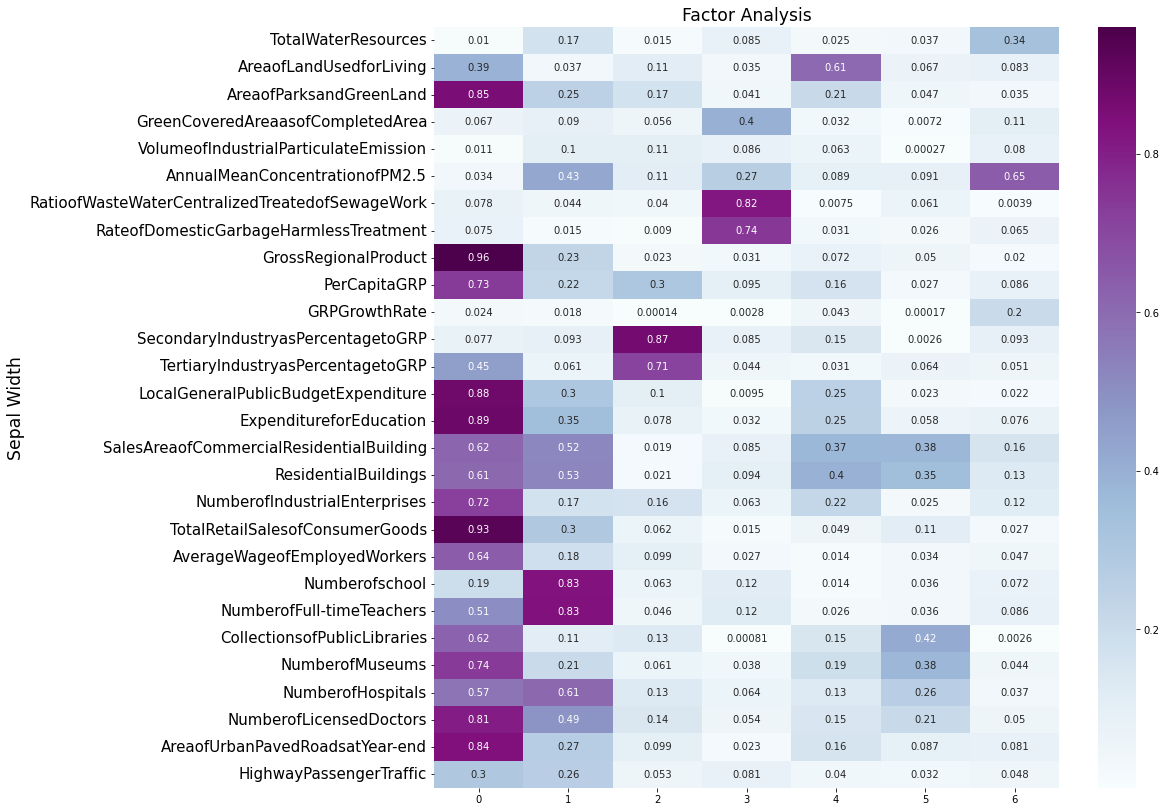

In [28]:
# plot
 
plt.figure(figsize = (14,14))
ax = sns.heatmap(faa_final, annot=True, cmap="BuPu")
 
ax.yaxis.set_tick_params(labelsize=15)
plt.title("Factor Analysis", fontsize="xx-large")
 
plt.ylabel("Sepal Width", fontsize="xx-large")

plt.show()
 

In [29]:
faa_7.transform(factors)

array([[ 6.18942908,  0.39938942,  1.81557926, ..., 10.53034402,
         1.05164041, -1.38561177],
       [ 2.01341891,  1.16108548,  1.06091157, ..., -0.25900284,
        -1.83068175, -1.47358995],
       [ 0.4351732 ,  1.97751094,  1.23766823, ...,  1.95301476,
        -0.01420072, -1.75356372],
       ...,
       [ 0.17541185, -1.48236548, -2.52655976, ...,  0.21488246,
        -0.76553986, -0.28658566],
       [-0.37889193, -0.57647751, -0.7550554 , ..., -0.03414207,
        -0.27479066,  1.16127483],
       [-0.63967654, -0.3141143 , -1.76247653, ...,  0.57057567,
        -0.11859878,  0.49778473]])

In [30]:
index7 = pd.DataFrame(faa_7.transform(factors), columns=list('0123456'))
index7.head()

,0,1,2,3,4,5,6
0,6.189429,0.399389,1.815579,0.603351,10.530344,1.051640,-1.385612
1,2.013419,1.161085,1.060912,0.438893,-0.259003,-1.830682,-1.473590
2,0.435173,1.977511,1.237668,0.328983,1.953015,-0.014201,-1.753564
3,0.709833,0.884580,-1.738064,0.464586,0.382551,-0.690330,-0.907490
4,-0.300343,-0.230194,0.761139,0.322560,-0.249767,-0.310283,-0.306999


In [31]:
#name each index
index7.rename(columns = {'0':'socio_economy',
                     '1':'public_service',
                     '2':'industrial_structure',
                     '3':'ecology',
                     '4':'living_capacity',
                     '5':'cultural_construture',
                     '6':'air_quality'}, 
          inplace = True)
index7.head()

,socio_economy,public_service,industrial_structure,ecology,living_capacity,cultural_construture,air_quality
0,6.189429,0.399389,1.815579,0.603351,10.530344,1.051640,-1.385612
1,2.013419,1.161085,1.060912,0.438893,-0.259003,-1.830682,-1.473590
2,0.435173,1.977511,1.237668,0.328983,1.953015,-0.014201,-1.753564
3,0.709833,0.884580,-1.738064,0.464586,0.382551,-0.690330,-0.907490
4,-0.300343,-0.230194,0.761139,0.322560,-0.249767,-0.310283,-0.306999


### 5 factors

In [81]:
# choose 5 factors
faa_5 = FactorAnalyzer(5,rotation='varimax')
faa_5.fit(df1)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [82]:
# common factor variance
faa_5.get_communalities()

array([0.05927046, 0.51222447, 0.8711443 , 0.19788064, 0.02657797,
       0.2680057 , 0.59150947, 0.57650734, 0.98271588, 0.71409913,
       0.01131512, 0.87158501, 0.65832223, 0.92987185, 0.94667339,
       0.92435771, 0.93631572, 0.62519583, 0.96920132, 0.4536356 ,
       0.71762608, 0.95648224, 0.48508051, 0.67167791, 0.7913497 ,
       0.97623664, 0.73629817, 0.17136853])

In [83]:
pd.DataFrame(faa_5.get_communalities(),index=df1.columns)

,0
WaterResources,0.059270
AreaofLandforLiving,0.512224
AreaofParksandGreen,0.871144
GreenCoveredAreaPercentage,0.197881
VolumeofIndustrialEmission,0.026578
MeanConcentrationofPM2.5,0.268006
RatioofSewageWork,0.591509
RateofGarbageTreatment,0.576507
GrossRegionalProduct,0.982716
PerCapitaGRP,0.714099


In [84]:
#eigenvalue after rotation
faa_5.get_eigenvalues()

(array([1.19563840e+01, 2.38905010e+00, 2.04482246e+00, 1.69012530e+00,
        1.19137617e+00, 1.14176585e+00, 1.00391677e+00, 9.41802131e-01,
        8.56948893e-01, 7.54008853e-01, 6.93853175e-01, 5.76477312e-01,
        5.16171868e-01, 4.78064651e-01, 3.62579339e-01, 2.92883108e-01,
        2.45152920e-01, 2.32759720e-01, 1.92512408e-01, 1.74951158e-01,
        8.12973965e-02, 6.13335747e-02, 4.25467016e-02, 3.41863037e-02,
        2.48568648e-02, 9.86422386e-03, 7.76483072e-03, 2.54396312e-03]),
 array([ 1.17842246e+01,  2.00943204e+00,  1.77262192e+00,  1.28604247e+00,
         7.80209165e-01,  4.15940153e-01,  3.57906600e-01,  3.14607905e-01,
         2.25987563e-01,  1.50213265e-01,  1.24570899e-01,  9.59699093e-02,
         2.32288812e-02, -2.81134951e-04, -1.36647846e-02, -1.95201027e-02,
        -3.10606049e-02, -4.76825243e-02, -6.09494957e-02, -6.77724998e-02,
        -8.61878214e-02, -1.04475929e-01, -1.37738123e-01, -1.76656333e-01,
        -1.91685859e-01, -2.39187409e-

In [85]:
pd.DataFrame(faa_5.get_eigenvalues())

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,11.956384,2.389050,2.044822,1.690125,1.191376,1.141766,1.003917,0.941802,0.856949,0.754009,...,0.192512,0.174951,0.081297,0.061334,0.042547,0.034186,0.024857,0.009864,0.007765,0.002544
1,11.784225,2.009432,1.772622,1.286042,0.780209,0.415940,0.357907,0.314608,0.225988,0.150213,...,-0.060949,-0.067772,-0.086188,-0.104476,-0.137738,-0.176656,-0.191686,-0.239187,-0.250439,-0.281125


In [86]:
# number of variables*number of factors
faa_5.loadings_

array([[ 9.13364941e-03,  1.65786996e-01, -1.50529333e-01,
        -2.54179499e-02,  9.16327003e-02],
       [ 4.82137317e-01,  6.48521452e-02,  8.57582380e-03,
        -1.21764452e-01, -5.10550833e-01],
       [ 9.02456013e-01,  1.78249130e-01,  4.26587057e-02,
        -1.31279233e-01, -7.67508324e-02],
       [ 7.18050879e-02,  9.37498279e-02,  4.21074410e-01,
         5.36920172e-02, -6.12302576e-02],
       [-7.50003930e-04,  1.19876406e-01,  6.14123237e-02,
         8.51363535e-02, -3.44583622e-02],
       [ 7.78850513e-02,  3.53830262e-01,  3.54907431e-01,
         1.03846951e-01,  5.38969391e-04],
       [-7.44361351e-02,  7.14861756e-02,  7.61802292e-01,
         2.07139236e-02, -9.30921572e-03],
       [ 6.00366234e-02, -2.47462749e-02,  7.56399504e-01,
         5.35964859e-03, -1.10288154e-02],
       [ 9.78176410e-01,  1.36374401e-01,  3.17421647e-02,
         2.05311965e-02,  7.65487685e-02],
       [ 6.67096135e-01, -2.85414226e-01,  1.32403360e-01,
         3.74497833e-01

In [87]:
pd.DataFrame(faa_5.loadings_,index=df1.columns)

,0,1,2,3,4
WaterResources,0.009134,0.165787,-0.150529,-0.025418,0.091633
AreaofLandforLiving,0.482137,0.064852,0.008576,-0.121764,-0.510551
AreaofParksandGreen,0.902456,0.178249,0.042659,-0.131279,-0.076751
GreenCoveredAreaPercentage,0.071805,0.093750,0.421074,0.053692,-0.061230
VolumeofIndustrialEmission,-0.000750,0.119876,0.061412,0.085136,-0.034458
MeanConcentrationofPM2.5,0.077885,0.353830,0.354907,0.103847,0.000539
RatioofSewageWork,-0.074436,0.071486,0.761802,0.020714,-0.009309
RateofGarbageTreatment,0.060037,-0.024746,0.756400,0.005360,-0.011029
GrossRegionalProduct,0.978176,0.136374,0.031742,0.020531,0.076549
PerCapitaGRP,0.667096,-0.285414,0.132403,0.374498,0.172746


In [88]:
# contribution
faa_5.get_factor_variance()
faa5_final = pd.DataFrame(np.abs(faa_5.loadings_),index=df1.columns)
print(faa5_final)

                                       0         1         2         3  \
WaterResources                  0.009134  0.165787  0.150529  0.025418   
AreaofLandforLiving             0.482137  0.064852  0.008576  0.121764   
AreaofParksandGreen             0.902456  0.178249  0.042659  0.131279   
GreenCoveredAreaPercentage      0.071805  0.093750  0.421074  0.053692   
VolumeofIndustrialEmission      0.000750  0.119876  0.061412  0.085136   
MeanConcentrationofPM2.5        0.077885  0.353830  0.354907  0.103847   
RatioofSewageWork               0.074436  0.071486  0.761802  0.020714   
RateofGarbageTreatment          0.060037  0.024746  0.756400  0.005360   
GrossRegionalProduct            0.978176  0.136374  0.031742  0.020531   
PerCapitaGRP                    0.667096  0.285414  0.132403  0.374498   
GRPGrowthRate                   0.016564  0.009951  0.038505  0.010178   
SecondaryIndustryasPercentage   0.002876  0.043380  0.114078  0.922910   
TertiaryIndustryasPercentage    0.4901

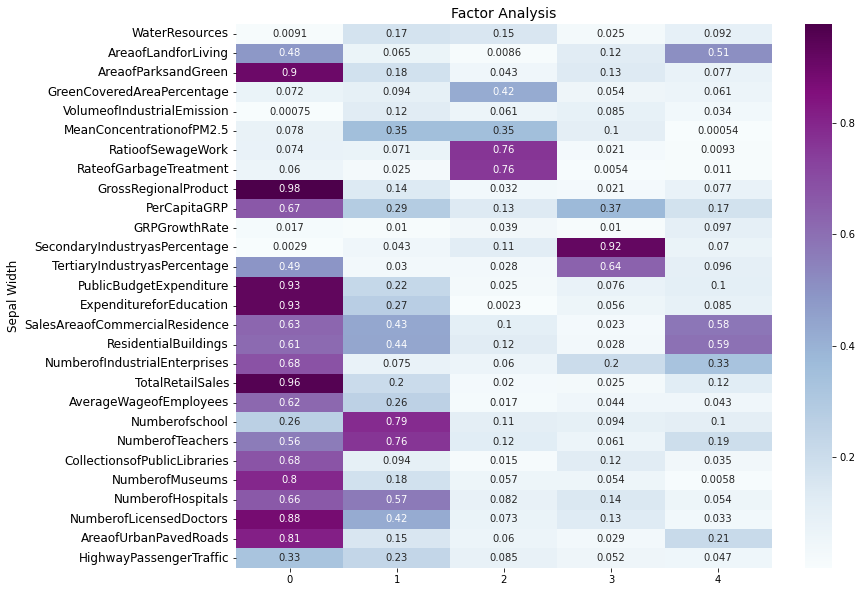

<Figure size 432x288 with 0 Axes>

In [95]:
# plot
 
plt.figure(figsize = (12,10))
ax = sns.heatmap(faa5_final, annot=True, cmap="BuPu")
 
ax.yaxis.set_tick_params(labelsize=12)
plt.title("Factor Analysis", fontsize=14)
 
plt.ylabel("Sepal Width", fontsize=12)

plt.show()
plt.savefig('Factor Analysis')

In [96]:
index5 = pd.DataFrame(faa_5.transform(factors), columns=list('01234'))
index5.head()

,0,1,2,3,4
0,7.761561,0.947699,0.122623,-2.047482,-8.963260
1,1.724189,0.883270,0.758523,-0.600034,-0.268963
2,0.971510,2.024969,0.547025,-1.295235,-2.104145
3,0.710415,0.865748,0.594688,1.745436,-0.591733
4,-0.334487,-0.319831,0.341058,-0.711139,-0.009525


In [97]:
#name each index
index5.rename(columns = {'0':'socio_economy',
                     '1':'public_service',
                     '2':'ecology',
                     '3':'industrial_structure',
                     '4':'living_capacity'}, 
          inplace = True)
index5.head()

,socio_economy,public_service,ecology,industrial_structure,living_capacity
0,7.761561,0.947699,0.122623,-2.047482,-8.963260
1,1.724189,0.883270,0.758523,-0.600034,-0.268963
2,0.971510,2.024969,0.547025,-1.295235,-2.104145
3,0.710415,0.865748,0.594688,1.745436,-0.591733
4,-0.334487,-0.319831,0.341058,-0.711139,-0.009525


## Clustering analysis

In [22]:
# Standardisation
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

index5_standardised = index5.copy()
for c in index5.columns.values:
    index5_standardised[c] = mms.fit_transform(index5[c].values.reshape(-1,1))
index5_standardised.head()

,socio_economy,public_service,ecology,industrial_structure,living_capacity
0,1.000000,0.304580,0.878982,0.115992,0.000000
1,0.307444,0.297247,0.993088,0.381164,0.674727
2,0.221103,0.427192,0.955137,0.253804,0.532306
3,0.191152,0.295252,0.963689,0.810853,0.649678
4,0.071290,0.160312,0.918178,0.360810,0.694861


In [29]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
X = index5_standardised
scores=[]#silhoutte Score
intra_sum_of_square_list = [] #elbow

max_cluster = 20
clusters = range(2,max_cluster)

for k in clusters:
    km = KMeans(n_clusters=k)
    labels=km.fit(X).labels_
    score=metrics.silhouette_score(X,labels)
    scores.append(score) #silhoutte Score
    intra_sum_of_square_list.append(km.inertia_) #elbow
scores

[0.5543041116812352,
 0.3002802620130689,
 0.31026874988296693,
 0.25829878542732077,
 0.28809449438727747,
 0.2806048126600095,
 0.2604069846253294,
 0.2719865083483057,
 0.27064791745808214,
 0.25060830541971174,
 0.27410074390248573,
 0.2639590075789663,
 0.2646817341017817,
 0.23881268622380952,
 0.2430839570528904,
 0.2396649987944707,
 0.24606224356359244,
 0.24890652120946913]

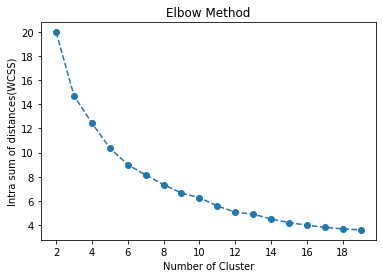

In [24]:
#Elbow
from matplotlib.pyplot import MultipleLocator
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Elbow Method")
ax.set_xlabel("Number of Cluster")
ax.set_ylabel("Intra sum of distances(WCSS)")
plt.plot(clusters,intra_sum_of_square_list,marker = 'o', linestyle = '--')


x_major_locator = MultipleLocator(2)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

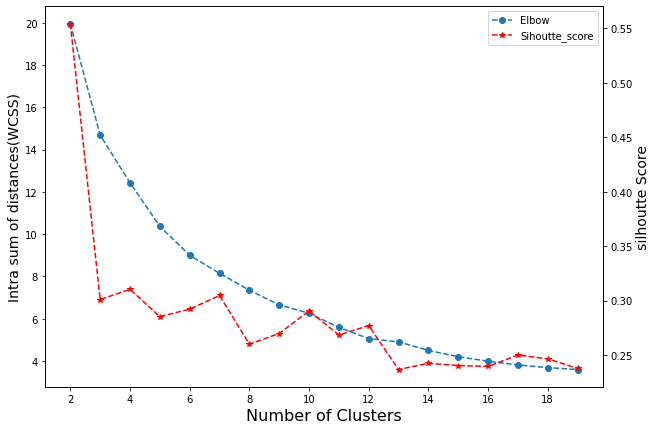

In [28]:
# combine two indicators together!
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()

Elbow, =ax1.plot(clusters,intra_sum_of_square_list, label="Elbow", marker = 'o', linestyle = '--')
Sihoutte_score, =ax2.plot(clusters, scores,label="Sihoutte_score", color='red', marker = '*', linestyle = '--')

ax1.set_xlabel("Number of Clusters",fontsize=16)
ax1.set_ylabel("Intra sum of distances(WCSS)",fontsize=14)
ax2.set_ylabel('silhoutte Score',fontsize=14)

x_major_locator = MultipleLocator(2)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)


#legend
legend = ax1.legend(handles=[Elbow,Sihoutte_score], loc='upper right')

### 2 clusters

In [116]:
# 2 cluster
random_state_seed = 100
kmeans_output2 = sklc.KMeans(n_clusters=2, random_state=random_state_seed).fit(X)

print(kmeans_output2) 

clustering_ids_kmeans2 = kmeans_output2.labels_

print(clustering_ids_kmeans2)

# combine the clustering IDs to the dataframe
cluster2 = X.assign(cluster_id = clustering_ids_kmeans2, city = df['City'], code = df['code'])

#Have a look at the result:
print(cluster2)

KMeans(n_clusters=2, random_state=100)
[0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0
 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1
 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1]
     socio_economy  public_service   ecology  industrial_structure  \
0         1.000000        0.304580  0.878982              0.115992   
1         0.307444        0.297247  0.993088              0.381164   
2         0.221103        0.427192  0.955137              0.253804   
3         0.191152        0.295252  0.963689              0.810853   
4         

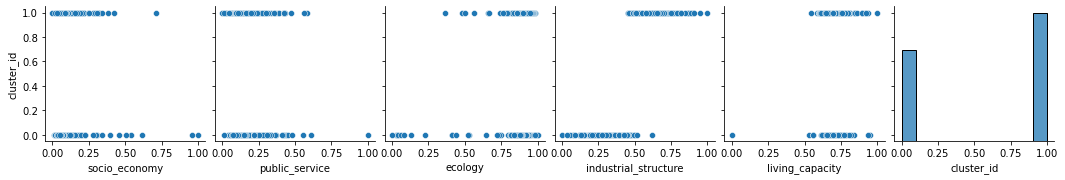

In [117]:
import seaborn as sns

sns.pairplot(cluster2.drop(columns=['city','code']), y_vars='cluster_id')
plt.savefig('cluster feature')

### 4 clusters

In [30]:
# Final clustering: 4 clusters
num_clusters = 4
random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(X)

print(kmeans_output) 

clustering_ids_kmeans = kmeans_output.labels_

print(clustering_ids_kmeans)

# combine the clustering IDs to the dataframe
cluster = X.assign(cluster_id = clustering_ids_kmeans, city = df['City'], code = df['code'])

#Have a look at the result:
print(cluster)

KMeans(n_clusters=4, random_state=100)
[0 2 2 3 2 3 2 2 2 2 3 2 2 1 2 3 3 3 3 3 2 3 3 3 2 3 3 2 2 3 2 2 3 2 3 3 3
 3 2 2 3 2 3 3 2 2 2 3 1 2 2 1 1 2 2 2 2 1 2 2 3 2 2 3 2 2 2 0 0 3 3 3 3 3
 3 3 3 3 3 3 3 0 3 2 3 3 3 2 2 2 3 2 3 3 3 2 3 3 3 3 2 3 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 2 2 2 0 3 3 3 3 3 3 3 3 3 2 3 2 3 3 0 3 3 3
 3 3 3 3 2 3 3 3 2 2 3 3 3 0 3 3 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 2 3 3 2 2
 3 0 2 0 3 3 3 3 2 2 3 3 2 2 2 2 2 3 3 3 2 2 2 3 2 2 3 3 2 2 2 3 2 2 2 2 2
 2 2 0 0 3 3 3 1 3 3 3 1 3 2 2 3 2 3 2 2 2 1 3 3 2 2 1 2 3 3 3 3 2 2 2 1 3
 3 2 1 1 2 2 3 3 2 3 3 3 1 3 2 3 3 2 2 2 2 2 3 3 2 2 2 3 3 3 3 2 3 2 3 1 3]
     socio_economy  public_service   ecology  industrial_structure  \
0         1.000000        0.304580  0.878982              0.115992   
1         0.307444        0.297247  0.993088              0.381164   
2         0.221103        0.427192  0.955137              0.253804   
3         0.191152        0.295252  0.963689              0.810853   
4         

### cluster characteristic

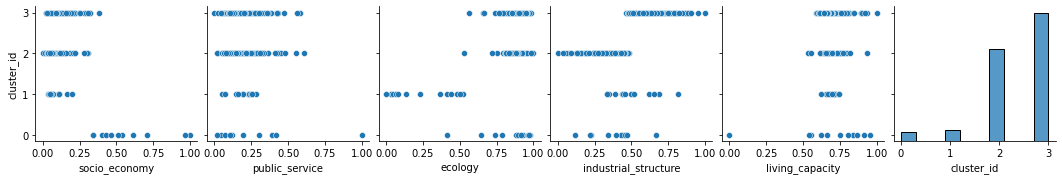

In [32]:
import seaborn as sns

sns.pairplot(cluster.drop(columns=['city','code']), y_vars='cluster_id')
plt.savefig('cluster feature')

In [ ]:
'''
ax2.boxplot([df_m_m_f["UrbanPop"].tolist()],
            labels = ['UrbanPop'],
            showmeans = True, 
            patch_artist = True, 
            boxprops = {'color':'orangered','facecolor':'pink'})

### mapping cluster

In [33]:
cluster_map = cities.merge(cluster,left_on = 'shi_code', right_on ='code', how='left')
cluster_map.info()
cluster_map.head(1)

NameError: name 'cities' is not defined

AttributeError: 'NoneType' object has no attribute 'set_title'

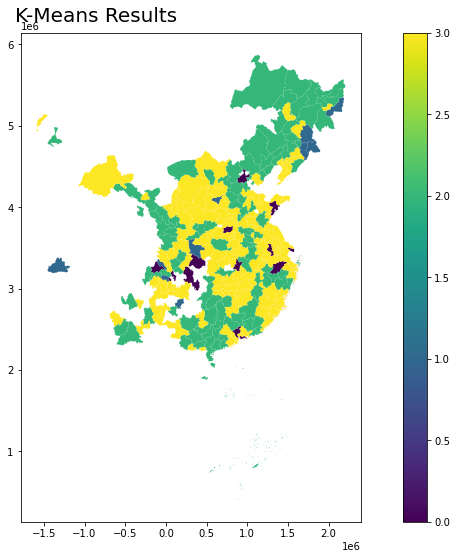

In [54]:
fig, ax = plt.subplots(1,1, figsize=(15,9))
fig.suptitle(f"K-Means Results", fontsize=20, y=0.92)
cluster_map.plot(ax=ax, column='cluster_id',legend=True)


ax.get_legend().set_title("clusters")  #set the legend title


city_of_london.plot(ax=ax,color='#17becf')
ax.axis('off') #don't plot the axes (bounding box)
#plt.savefig('cluster_map.png')

## Regression

### merge data

In [34]:
data = cluster.assign( population = df['ResidentPopulation'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         296 non-null    float64
 1   public_service        296 non-null    float64
 2   ecology               296 non-null    float64
 3   industrial_structure  296 non-null    float64
 4   living_capacity       296 non-null    float64
 5   cluster_id            296 non-null    int32  
 6   city                  296 non-null    object 
 7   code                  296 non-null    int64  
 8   population            296 non-null    int64  
dtypes: float64(5), int32(1), int64(2), object(1)
memory usage: 19.8+ KB


,socio_economy,public_service,ecology,industrial_structure,living_capacity,cluster_id,city,code,population
0,1.000000,0.304580,0.878982,0.115992,0.000000,0,Beijing,1101,2189
1,0.307444,0.297247,0.993088,0.381164,0.674727,2,Tianjin,1202,1387
2,0.221103,0.427192,0.955137,0.253804,0.532306,2,Shijiazhuang,1301,1124
3,0.191152,0.295252,0.963689,0.810853,0.649678,3,Tangshan,1302,772
4,0.071290,0.160312,0.918178,0.360810,0.694861,2,Qinhuangdao,1303,314


In [35]:
data['population'] = data['population'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         296 non-null    float64
 1   public_service        296 non-null    float64
 2   ecology               296 non-null    float64
 3   industrial_structure  296 non-null    float64
 4   living_capacity       296 non-null    float64
 5   cluster_id            296 non-null    int32  
 6   city                  296 non-null    object 
 7   code                  296 non-null    int64  
 8   population            296 non-null    float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 19.8+ KB


### slipt data by cluster_id

In [36]:
data0=[]
data0 = data[data['cluster_id']==0]
data0.info()
data0.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 225
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         11 non-null     float64
 1   public_service        11 non-null     float64
 2   ecology               11 non-null     float64
 3   industrial_structure  11 non-null     float64
 4   living_capacity       11 non-null     float64
 5   cluster_id            11 non-null     int32  
 6   city                  11 non-null     object 
 7   code                  11 non-null     int64  
 8   population            11 non-null     float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 836.0+ bytes


,socio_economy,public_service,ecology,industrial_structure,living_capacity,cluster_id,city,code,population
0,1.000000,0.304580,0.878982,0.115992,0.000000,0,Beijing,1101,2189.0
67,0.962315,0.103120,0.414651,0.443062,0.556105,0,Shanghai,3102,2488.0
68,0.398644,0.041176,0.644947,0.428640,0.838653,0,Nanjing,3201,932.0
81,0.539856,0.069983,0.896698,0.342735,0.660582,0,Hangzhou,3301,1197.0
129,0.342004,0.195849,0.928691,0.394845,0.749394,0,Qingdao,3702,1011.0


In [37]:
data1=[]
data1 = data[data['cluster_id']==1]
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 13 to 294
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         14 non-null     float64
 1   public_service        14 non-null     float64
 2   ecology               14 non-null     float64
 3   industrial_structure  14 non-null     float64
 4   living_capacity       14 non-null     float64
 5   cluster_id            14 non-null     int32  
 6   city                  14 non-null     object 
 7   code                  14 non-null     int64  
 8   population            14 non-null     float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 1.0+ KB


,socio_economy,public_service,ecology,industrial_structure,living_capacity,cluster_id,city,code,population
13,0.165792,0.230185,0.229703,0.433344,0.726404,1,Taiyuan,1401,532.0
48,0.108329,0.255137,0.030217,0.504719,0.653570,1,Jilin,2202,362.0
51,0.069131,0.194776,0.034486,0.446086,0.715512,1,Tonghua,2205,130.0
52,0.060189,0.143791,0.043817,0.337381,0.725980,1,Baishan,2206,95.0
57,0.037630,0.188783,0.064025,0.350191,0.685277,1,Jixi,2303,149.0


In [38]:
data2=[]
data2 = data[data['cluster_id']==2]
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 292
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         113 non-null    float64
 1   public_service        113 non-null    float64
 2   ecology               113 non-null    float64
 3   industrial_structure  113 non-null    float64
 4   living_capacity       113 non-null    float64
 5   cluster_id            113 non-null    int32  
 6   city                  113 non-null    object 
 7   code                  113 non-null    int64  
 8   population            113 non-null    float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 8.4+ KB


,socio_economy,public_service,ecology,industrial_structure,living_capacity,cluster_id,city,code,population
1,0.307444,0.297247,0.993088,0.381164,0.674727,2,Tianjin,1202,1387.0
2,0.221103,0.427192,0.955137,0.253804,0.532306,2,Shijiazhuang,1301,1124.0
4,0.071290,0.160312,0.918178,0.360810,0.694861,2,Qinhuangdao,1303,314.0
6,0.058541,0.437065,0.920479,0.448341,0.635513,2,Xingtai,1305,711.0
7,0.110735,0.555719,0.928428,0.359727,0.555847,2,Baoding,1306,1155.0


In [39]:
data3=[]
data3 = data[data['cluster_id']==3]
data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 295
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         158 non-null    float64
 1   public_service        158 non-null    float64
 2   ecology               158 non-null    float64
 3   industrial_structure  158 non-null    float64
 4   living_capacity       158 non-null    float64
 5   cluster_id            158 non-null    int32  
 6   city                  158 non-null    object 
 7   code                  158 non-null    int64  
 8   population            158 non-null    float64
dtypes: float64(6), int32(1), int64(1), object(1)
memory usage: 11.7+ KB


,socio_economy,public_service,ecology,industrial_structure,living_capacity,cluster_id,city,code,population
3,0.191152,0.295252,0.963689,0.810853,0.649678,3,Tangshan,1302,772.0
5,0.028540,0.583035,0.967104,0.582955,0.650518,3,Handan,1304,941.0
10,0.131774,0.338211,0.925018,0.495319,0.620618,3,Cangzhou,1309,730.0
15,0.083937,0.098905,0.907718,0.559624,0.637971,3,Yangquan,1403,132.0
16,0.097245,0.208967,0.875932,0.721380,0.647136,3,Changzhi,1404,318.0


In [61]:
'''
datai = []
for i in ['0','1','2','3','4']:
    datai = data[data['cluster_id']==i]
    datai.info()
'''

"\ndatai = []\nfor i in ['0','1','2','3','4']:\n    datai = data[data['cluster_id']==i]\n    datai.info()\n"

In [40]:
'''
data_0 = []
data_1 = []
data_2 = []
data_3 = []
'''

data_0 = data0.drop(columns = ['cluster_id', 'city', 'code'])
data_1 = data1.drop(columns = ['cluster_id', 'city', 'code'])
data_2 = data2.drop(columns = ['cluster_id', 'city', 'code'])
data_3 = data3.drop(columns = ['cluster_id', 'city', 'code'])

data_0.info()
data_1.info()
data_2.info()
data_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 225
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         11 non-null     float64
 1   public_service        11 non-null     float64
 2   ecology               11 non-null     float64
 3   industrial_structure  11 non-null     float64
 4   living_capacity       11 non-null     float64
 5   population            11 non-null     float64
dtypes: float64(6)
memory usage: 616.0 bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 13 to 294
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   socio_economy         14 non-null     float64
 1   public_service        14 non-null     float64
 2   ecology               14 non-null     float64
 3   industrial_structure  14 non-null     float64
 4   living_capacity       14 non-

In [41]:
data_0.head()

,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
0,1.000000,0.304580,0.878982,0.115992,0.000000,2189.0
67,0.962315,0.103120,0.414651,0.443062,0.556105,2488.0
68,0.398644,0.041176,0.644947,0.428640,0.838653,932.0
81,0.539856,0.069983,0.896698,0.342735,0.660582,1197.0
129,0.342004,0.195849,0.928691,0.394845,0.749394,1011.0


In [118]:
# mean var median of cluster 0
col_list = data_0.columns[0:]
mean_list0 = data_0.mean().tolist()
var_list0 = data_0.var().tolist()
median_list0 = data_0.median().tolist()

all_list0 = []
all_list0.append(mean_list0)
all_list0.append(var_list0)
all_list0.append(median_list0)


index_list = ["mean", "var", "median"]

desc0 = pd.DataFrame(all_list0, columns=col_list, index=index_list)
desc0

,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
mean,0.572803,0.250650,0.828985,0.383882,0.682820,1750.272727
var,0.053139,0.080688,0.030039,0.022971,0.071067,502710.218182
median,0.507896,0.118421,0.896698,0.428640,0.749394,1763.000000


In [120]:
# mean var median of cluster 1
col_list = data_1.columns[0:]
mean_list1 = data_1.mean().tolist()
var_list1 = data_1.var().tolist()
median_list1 = data_1.median().tolist()

all_list1 = []
all_list1.append(mean_list1)
all_list1.append(var_list1)
all_list1.append(median_list1)


index_list = ["mean", "var", "median"]

desc1 = pd.DataFrame(all_list1, columns=col_list, index=index_list)
desc1

,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
mean,0.085899,0.193059,0.238914,0.503967,0.700282,239.142857
var,0.002247,0.004549,0.041790,0.021093,0.001176,32744.901099
median,0.067736,0.192749,0.181657,0.477972,0.707964,199.000000


In [121]:
# mean var median of cluster 2
col_list = data_2.columns[0:]
mean_list2 = data_2.mean().tolist()
var_list2 = data_2.var().tolist()
median_list2 = data_2.median().tolist()

all_list2 = []
all_list2.append(mean_list2)
all_list2.append(var_list2)
all_list2.append(median_list2)


index_list = ["mean", "var", "median"]

desc2 = pd.DataFrame(all_list2, columns=col_list, index=index_list)
desc2

,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
mean,0.074393,0.206998,0.882622,0.333370,0.694044,411.716814
var,0.002962,0.012075,0.003019,0.013120,0.002297,83304.454804
median,0.059089,0.192714,0.886925,0.359727,0.689947,310.000000


In [123]:
# mean var median of cluster 3
col_list = data_3.columns[0:]
mean_list3 = data_3.mean().tolist()
var_list3 = data_3.var().tolist()
median_list3 = data_3.median().tolist()

all_list3 = []
all_list3.append(mean_list3)
all_list3.append(var_list3)
all_list3.append(median_list3)


index_list = ["mean", "var", "median"]

desc3 = pd.DataFrame(all_list3, columns=col_list, index=index_list)
desc3

,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
mean,0.104743,0.185930,0.895354,0.610213,0.697187,403.955696
var,0.003806,0.009000,0.003428,0.012183,0.004640,62069.736878
median,0.085466,0.163372,0.906896,0.586170,0.682099,355.000000


In [42]:
# standarise
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_0st = data_0.copy()
for c in data_0.columns.values:
    data_0st[c] = mms.fit_transform(data_0[c].values.reshape(-1,1))
data_0st.head()

data_1st = data_1.copy()
for c in data_1.columns.values:
    data_1st[c] = mms.fit_transform(data_1[c].values.reshape(-1,1))
data_1st.head()

data_2st = data_2.copy()
for c in data_2.columns.values:
    data_2st[c] = mms.fit_transform(data_2[c].values.reshape(-1,1))
data_2st.head()

data_3st = data_3.copy()
for c in data_3.columns.values:
    data_3st[c] = mms.fit_transform(data_3[c].values.reshape(-1,1))
data_3st.head()


,socio_economy,public_service,ecology,industrial_structure,living_capacity,population
3,0.471205,0.506406,0.952968,0.647534,0.148552,0.595659
5,0.022005,1.000000,0.961128,0.222856,0.150593,0.731511
10,0.307180,0.580087,0.860571,0.059550,0.077922,0.561897
15,0.175033,0.169639,0.819236,0.179380,0.120099,0.081190
16,0.211797,0.358413,0.743291,0.480805,0.142374,0.230707


### Multiple regression

#### cluster id = 0

In [43]:
data0_ml = ols('population ~ socio_economy + public_service + industrial_structure + ecology + living_capacity', 
               data=data_0st).fit()
data0_ml.summary()

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     17.14
Date:                Sat, 07 Jan 2023   Prob (F-statistic):            0.00365
Time:                        20:24:47   Log-Likelihood:                 13.689
No. Observations:                  11   AIC:                            -15.38
Df Residuals:                       5   BIC:                            -12.99
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8726      0.414     -2.107      0.089      -1.937       0.192
socio_economy            1.1556      0.281      4.105      0.009       0.432       1.879
public_service           0.6911      0.131      5.294      0.003       0.356       1.027
industrial_structure    -0.0567      0.153     -0.371      0.726      -0.450       0.336
ecology                  0.1344      0.173      0.779      0.471      -0.309       0.578
living_capacity          0.8215      0.339      2.423      0.060      -0.050       1.693
==============================================================================
Omnibus:                        0.513   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.536
Skew:                          -0.204   Prob(JB):                        0.765
Kurtosis:                       1.999   Cond. No.                         30.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

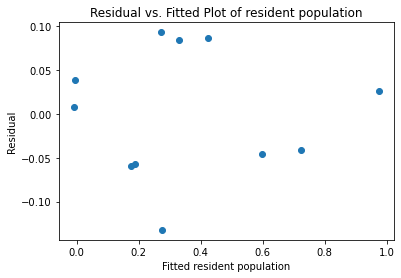

In [49]:
# plot 
plt.scatter(data0_ml.fittedvalues, data0_ml.resid)
# adding title and labels
plt.xlabel('Fitted resident population')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of resident population')
plt.show()

#### cluster id = 1

In [44]:
data1_ml = ols('population ~ socio_economy + public_service + industrial_structure + ecology + living_capacity', 
               data=data_1st).fit()
data1_ml.summary()

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     30.75
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           5.08e-05
Time:                        20:25:16   Log-Likelihood:                 17.591
No. Observations:                  14   AIC:                            -23.18
Df Residuals:                       8   BIC:                            -19.35
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.4021      0.127     -3.178      0.013      -0.694      -0.110
socio_economy            0.6711      0.095      7.056      0.000       0.452       0.890
public_service           0.6816      0.089      7.696      0.000       0.477       0.886
industrial_structure    -0.0842      0.121     -0.693      0.508      -0.364       0.196
ecology                  0.0643      0.078      0.821      0.435      -0.116       0.245
living_capacity          0.2313      0.120      1.929      0.090      -0.045       0.508
==============================================================================
Omnibus:                        0.538   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.531
Skew:                          -0.371   Prob(JB):                        0.767
Kurtosis:                       2.400   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

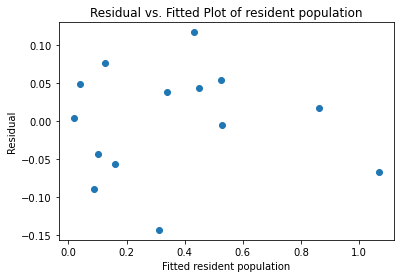

In [50]:
# plot 
plt.scatter(data1_ml.fittedvalues, data1_ml.resid)
# adding title and labels
plt.xlabel('Fitted resident population')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of resident population')
plt.show()

#### cluster id = 2

In [51]:
data2_ml = ols('population ~ socio_economy + public_service + industrial_structure + ecology + living_capacity', 
               data=data_2st).fit()
data2_ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     460.8
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           1.20e-70
Time:                        20:35:02   Log-Likelihood:                 191.57
No. Observations:                 113   AIC:                            -371.1
Df Residuals:                     107   BIC:                            -354.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2659      0.032     -8.421      0.000      -0.328      -0.203
socio_economy            0.5913      0.026     22.434      0.000       0.539       0.644
public_service           0.8869      0.026     34.388      0.000       0.836       0.938
industrial_structure    -0.0817      0.020     -4.108      0.000      -0.121      -0.042
ecology                  0.0911      0.041      2.218      0.029       0.010       0.173
living_capacity          0.2719      0.037      7.284      0.000       0.198       0.346
==============================================================================
Omnibus:                        6.886   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                8.542
Skew:                           0.324   Prob(JB):                       0.0140
Kurtosis:                       4.181   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

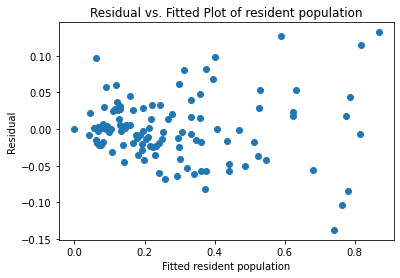

In [52]:
# plot 
plt.scatter(data2_ml.fittedvalues, data2_ml.resid)
# adding title and labels
plt.xlabel('Fitted resident population')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of resident population')
plt.show()

#### cluster id = 3

In [56]:
data3_ml = ols('population ~ socio_economy + public_service + industrial_structure + ecology + living_capacity', 
               data=data_3st).fit()
data3_ml.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     419.1
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           5.64e-87
Time:                        20:41:28   Log-Likelihood:                 243.19
No. Observations:                 158   AIC:                            -474.4
Df Residuals:                     152   BIC:                            -456.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2250      0.027     -8.290      0.000      -0.279      -0.171
socio_economy            0.7470      0.034     22.046      0.000       0.680       0.814
public_service           0.7892      0.027     29.313      0.000       0.736       0.842
industrial_structure    -0.0629      0.022     -2.924      0.004      -0.105      -0.020
ecology                  0.0348      0.031      1.138      0.257      -0.026       0.095
living_capacity          0.3376      0.034      9.987      0.000       0.271       0.404
==============================================================================
Omnibus:                       73.159   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.929
Skew:                           1.337   Prob(JB):                    3.54e-166
Kurtosis:                      13.420   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

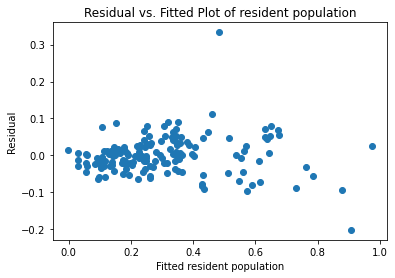

In [54]:
# plot 
plt.scatter(data3_ml.fittedvalues, data3_ml.resid)
# adding title and labels
plt.xlabel('Fitted resident population')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of resident population')
plt.show()

#### VIF

In [69]:
'''
# multicollinearity is still strong
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0] # [0] 是为了以防多个值同时是最大值，只去除一个
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

IndentationError: unexpected indent (299528040.py, line 10)

In [ ]:
'''
# multicollinearity is strong, drop it
data_3_new = drop_column_using_vif_(data_3.drop('population', axis=1))
data_3_new.head()
data3_ml_new = sm.OLS(endog=data_3[['population']], exog=sm.add_constant(data_3_new)).fit()
data3_ml_new.summary()